In [2]:
pip install conllu

In [3]:
import conllu
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import spacy
from wordcloud import WordCloud
from scipy.stats import chi2_contingency
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
with open("en_gum-ud-train.conllu", "r", encoding="utf-8") as f:
    data = f.read()
sentences = conllu.parse(data)

In [5]:
nlp = spacy.load("en_core_web_sm")

##EDA - Exploratory Data Analysis

### Basic Statistics Function

The `basic_stats` function computes some general statistics on a list of sentences:
- **n_sentences**: Number of sentences in the input.
- **n_tokens**: Total number of tokens across all sentences.
- **avg_tokens_per_sent**: Average number of tokens per sentence.
- **unique_lemmas**: Number of unique lemmas (lowercased) in the sentences.

```python
def basic_stats(sentences):
    stats = {
        'n_sentences': len(sentences),
        'n_tokens': sum(len(sent) for sent in sentences),
        'avg_tokens_per_sent': round(sum(len(sent) for sent in sentences)/len(sentences), 2),
        'unique_lemmas': len(set(token['lemma'].lower() for sent in sentences for token in sent if token['lemma']))
    }
    return stats


In [5]:
def basic_stats(sentences):
    stats = {
        'n_sentences': len(sentences),
        'n_tokens': sum(len(sent) for sent in sentences),
        'avg_tokens_per_sent': round(sum(len(sent) for sent in sentences)/len(sentences), 2),
        'unique_lemmas': len(set(token['lemma'].lower() for sent in sentences for token in sent if token['lemma']))
    }
    return stats

In [6]:
stats = basic_stats(sentences)
print("Statistiques générales:")
for k, v in stats.items():
    print(f"- {k}: {v}")

Statistiques générales:
- n_sentences: 839
- n_tokens: 21560
- avg_tokens_per_sent: 25.7
- unique_lemmas: 3672


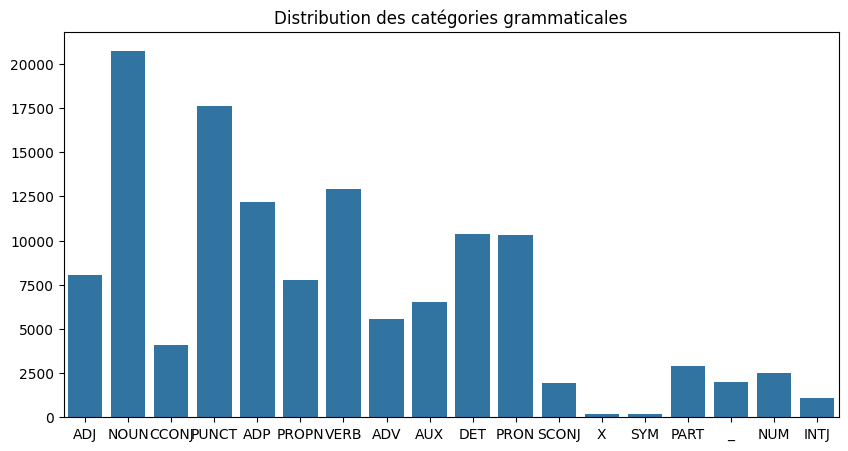

In [10]:
pos_counter = Counter(token['upostag'] for sent in sentences for token in sent)
plt.figure(figsize=(10,5))
sns.barplot(x=list(pos_counter.keys()), y=list(pos_counter.values()))
plt.title('Distribution des catégories grammaticales')
plt.show()


###Lemma Frequency Plot
This block generates a bar plot of the 20 most frequent lemmas, excluding punctuation and symbols.

<ipython-input-11-ed106147f3c1>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[v[1] for v in lemma_counter],


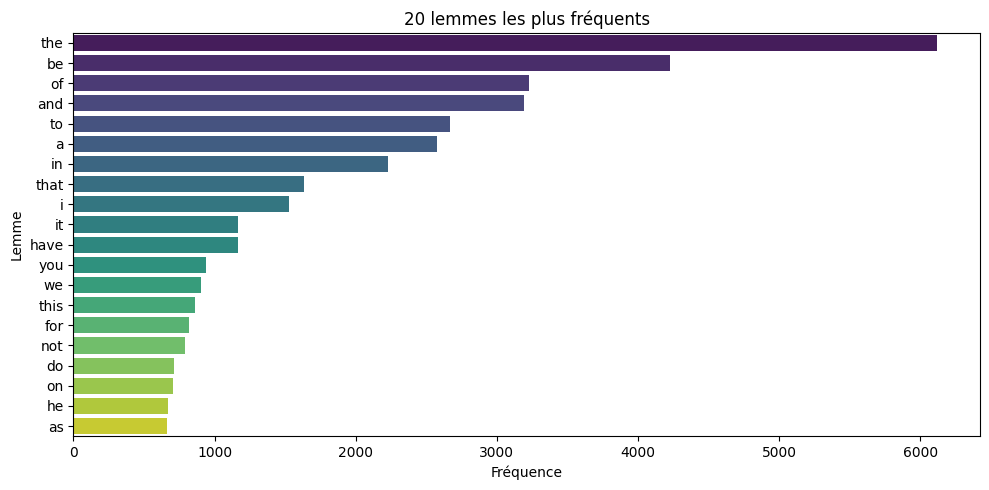

In [11]:
lemmas = [token['lemma'].lower()
          for sent in sentences
          for token in sent
          if token['upostag'] not in ['PUNCT', 'SYM']
          and token['lemma'] != '_']

lemma_counter = Counter(lemmas).most_common(20)

plt.figure(figsize=(10,5))
sns.barplot(x=[v[1] for v in lemma_counter],
            y=[v[0] for v in lemma_counter],
            palette="viridis")
plt.title('20 lemmes les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Lemme')
plt.tight_layout()
plt.show()

###Morphological Analysis
The  `analyze_morph ` function analyzes the tense and gender of tokens in sentences, counting occurrences of each.

In [12]:
def analyze_morph(sentences):
    tense = Counter()
    gender = Counter()
    for sent in sentences:
        for token in sent:
            feats = token['feats']
            if feats:
                if 'Tense' in feats:
                    tense[feats['Tense']] += 1
                if 'Gender' in feats:
                    gender[feats['Gender']] += 1
    return tense, gender

In [13]:
tense, gender = analyze_morph(sentences)
print("\nTemps verbaux:", tense)
print("Genres grammaticaux:", gender)


Temps verbaux: Counter({'Pres': 7054, 'Past': 6340})
Genres grammaticaux: Counter({'Neut': 1312, 'Masc': 1093, 'Fem': 581})


##Syntaxic Analysis


### Dependency Relations Counter

This block counts the occurrences of dependency relations (`deprel`) for each token in the sentences and displays the 10 most common relations.


In [14]:
deprel_counter = Counter(token['deprel'] for sent in sentences for token in sent)
print("\nTop relations de dépendance:", deprel_counter.most_common(10))



Top relations de dépendance: [('punct', 17590), ('case', 11908), ('det', 10013), ('nsubj', 9199), ('root', 6983), ('amod', 6576), ('advmod', 5824), ('obl', 5543), ('obj', 5443), ('nmod', 5183)]


###Part-of-Speech (POS) N-grams Function
The `get_pos_ngrams` function generates n-grams of POS tags (default is 3), counting their occurrences across all sentences.



In [15]:
def get_pos_ngrams(sentences, n=3):
    ngrams = Counter()
    for sent in sentences:
        pos = [token['upostag'] for token in sent]
        for i in range(len(pos)-n+1):
            ngrams[tuple(pos[i:i+n])] += 1
    return ngrams

In [ ]:
pos_trigrams = get_pos_ngrams(sentences).most_common(10)
print("\nStructures syntaxiques fréquentes (POS trigrammes):", pos_trigrams)



Structures syntaxiques fréquentes (POS trigrammes): [(('ADP', 'DET', 'NOUN'), 3189), (('DET', 'ADJ', 'NOUN'), 2417), (('NOUN', 'ADP', 'DET'), 2280), (('DET', 'NOUN', 'ADP'), 2265), (('ADJ', 'NOUN', 'PUNCT'), 2167), (('DET', 'NOUN', 'PUNCT'), 1956), (('VERB', 'DET', 'NOUN'), 1812), (('NOUN', 'ADP', 'NOUN'), 1605), (('ADJ', 'NOUN', 'ADP'), 1493), (('_', 'PRON', 'AUX'), 1411)]


### Dependency Length Calculation

This block calculates the average length of dependency relations across all sentences. It computes the absolute difference between the token's index and its "head" (the index of the word it depends on), and then computes the average of these lengths.

In [ ]:
dep_length_list = [
    abs(token["head"] - i)
    for sent in sentences
    for i, token in enumerate(sent)
    if token.get("head") is not None and isinstance(token["head"], int) and token["head"] > 0
]
print(f"\nLongueur moyenne des dépendances: {sum(dep_length_list)/len(dep_length_list):.2f}")




Longueur moyenne des dépendances: 3.58


### Frequent Root Verbs

This block identifies the most frequent root verbs in the sentences. It extracts the lemma of tokens with the dependency relation `'root'` and then counts the 10 most common root verbs.

The output displays the most frequent root verbs, helping to identify key verbs in the sentences.


In [ ]:
roots = [token['lemma'] for sent in sentences for token in sent if token['deprel'] == 'root']
print("\nVerbes racines fréquents:", Counter(roots).most_common(10))


Verbes racines fréquents: [('have', 288), ('be', 227), ('say', 192), ('know', 143), ('think', 140), ('get', 137), ('go', 135), ('make', 116), ('take', 100), ('do', 92)]






##Discourse Analysis

### Chi-Squared Test for Connector Distribution Across Genres

This block analyzes the distribution of specific connectors (e.g., "however", "therefore", "moreover") across different genres in the sentences. It calculates how often each connector appears in sentences of each genre, then performs a chi-squared test to assess if there are significant differences in the usage of connectors between genres.

The result shows the p-value, indicating whether the differences in connector usage between genres are statistically significant.

- **p-value**: The smaller the p-value, the stronger the evidence against the null hypothesis (which states that the connector distribution is the same across genres).


In [ ]:
connecteurs = {'however', 'therefore', 'moreover', 'because', 'although', 'thus', 'nevertheless'}
connectors_genre = defaultdict(Counter)
for sent in sentences:
    genre = sent.metadata.get('genre', 'inconnu')
    for token in sent:
        if token['lemma'].lower() in connecteurs:
            connectors_genre[genre][token['lemma']] += 1


In [ ]:
genres = list(connectors_genre.keys())
data = [list(connectors_genre[g].values()) for g in genres]
chi2, p, _, _ = chi2_contingency(data)
print(f"\nSignificativité des différences entre genres (connecteurs): p={p:.4f}")


Significativité des différences entre genres (connecteurs): p=1.0000




##Comparison Across Text Genres

### Distribution of POS Tags by Genre (Pie Chart)

This block analyzes the distribution of Part-of-Speech (POS) tags across different genres. It counts the occurrences of each POS tag for every genre, then generates a pie chart that visualizes the proportion of each POS tag within all genres.

- **Data Preparation**: The code first counts the POS tags for each genre, storing the results in a nested dictionary.
- **Pie Chart Creation**: The labels and sizes for the pie chart are prepared by filtering out certain POS tags (e.g., '_'). The chart then visualizes the percentage of each POS tag in the genres.

The pie chart provides a clear visual representation of how POS tags are distributed among the genres.


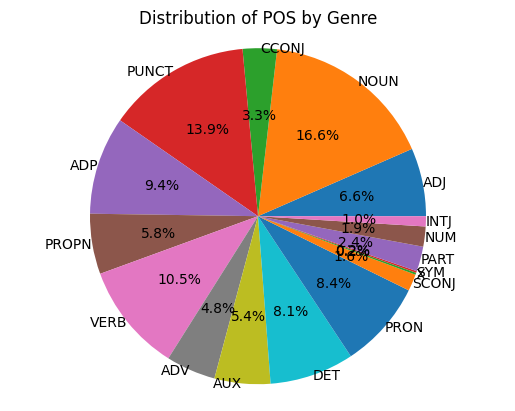

In [ ]:
from pickle import NONE
pos_genre = defaultdict(lambda: defaultdict(int))
for sent in sentences:
    genre = sent.metadata.get('genre', 'inconnu')
    for token in sent:
        pos_genre[genre][token['upostag']] += 1

# Data preparation for pie chart
genre_pos_counts = defaultdict(int)
for genre, pos_counts in pos_genre.items():
    for pos, count in pos_counts.items():
        genre_pos_counts[(genre, pos)] += count

# Creating the pie chart
# Filter out labels containing '_'
labels = [f"{pos}" for genre, pos in genre_pos_counts.keys() if pos != '_']
sizes = [value for (genre, pos), value in genre_pos_counts.items() if pos != '_']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%',labeldistance=1)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of POS by Genre')
plt.show()

In [ ]:
print(labels)

['ADJ', 'NOUN', 'CCONJ', 'PUNCT', 'ADP', 'PROPN', 'VERB', 'ADV', 'AUX', 'DET', 'PRON', 'SCONJ', 'X', 'SYM', 'PART', '_', 'NUM', 'INTJ']


##Visualisations

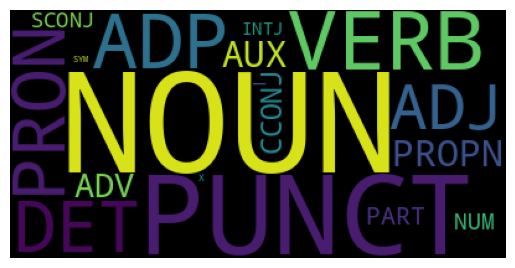

In [ ]:
pos_cloud = WordCloud().generate_from_frequencies(pos_counter)
plt.imshow(pos_cloud)
plt.axis('off')
plt.show()


##Named Entity Recognition




### Named Entity Recognition (NER) and Visualization

This block extracts named entities (e.g., locations, dates, organizations) from the sentences and visualizes their frequencies.

1. **Named Entity Extraction**: The `extract_named_entities` function processes each sentence, applying the `spaCy` NER model (`nlp(text)`) to identify and count named entities. It also counts occurrences of named entities by genre.

2. **Visualization**: The code generates a bar plot that shows the frequency of each type of named entity (e.g., `PERSON`, `ORG`, `GPE`). The x-axis represents the type of entity, and the y-axis represents its frequency.

- **Bar Plot**: The bar plot visualizes the distribution of named entity types, helping to identify the most common entities in the dataset.




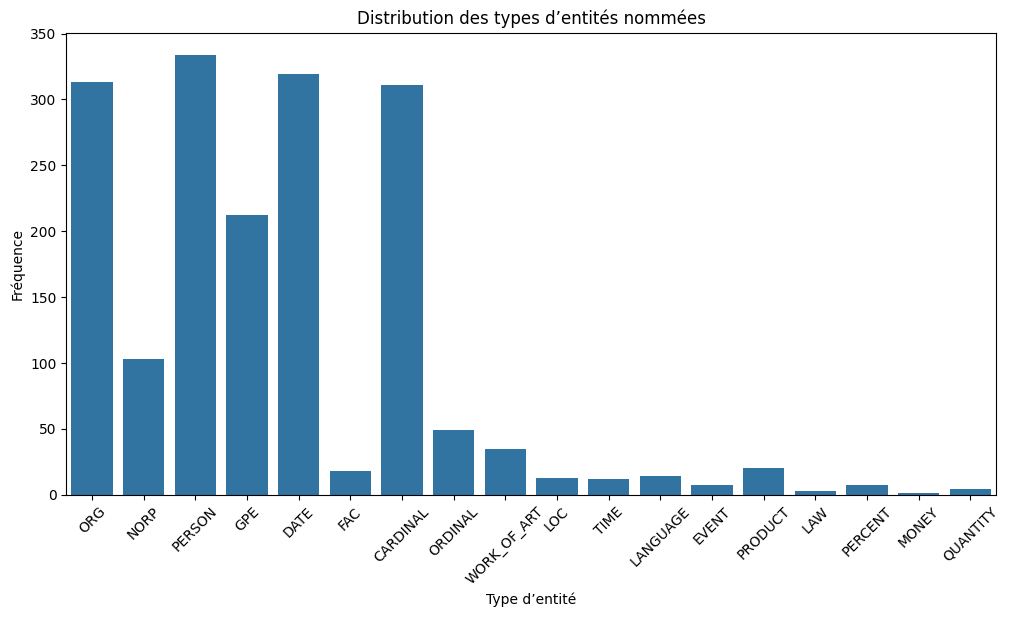

In [10]:
def extract_named_entities(sentences):
    ner_counter = Counter()
    ner_genre = defaultdict(Counter)

    for sent in sentences:
        genre = sent.metadata.get('genre', 'inconnu')
        text = " ".join([token['form'] for token in sent])
        doc = nlp(text)

        for ent in doc.ents:
            ner_counter[ent.label_] += 1
            ner_genre[genre][ent.label_] += 1

    return ner_counter, ner_genre

ner_counter, ner_genre = extract_named_entities(sentences)

# F20. Visualisation des fréquences des entités nommées
plt.figure(figsize=(12, 6))
sns.barplot(x=list(ner_counter.keys()), y=list(ner_counter.values()))
plt.title('Distribution des types d’entités nommées')
plt.xlabel('Type d’entité')
plt.ylabel('Fréquence')
plt.xticks(rotation=45)
plt.show()






### Heatmap of Named Entity Distribution by Genre

This block visualizes the distribution of named entities across different genres using a heatmap.

1. **Data Preparation**: The `ner_genre` data (which holds named entity counts by genre) is converted into a pandas DataFrame (`df_ner`). Missing values are filled with zeros, and the data is normalized by dividing each value by the total sum of its respective column (genre).

2. **Heatmap Creation**: The `sns.heatmap` function generates a heatmap where each cell shows the normalized frequency of a named entity type in a particular genre. The color intensity reflects the frequency of each entity, with annotations displaying the exact values.

- **Heatmap**: The heatmap provides a clear visual representation of how named entities are distributed across genres.


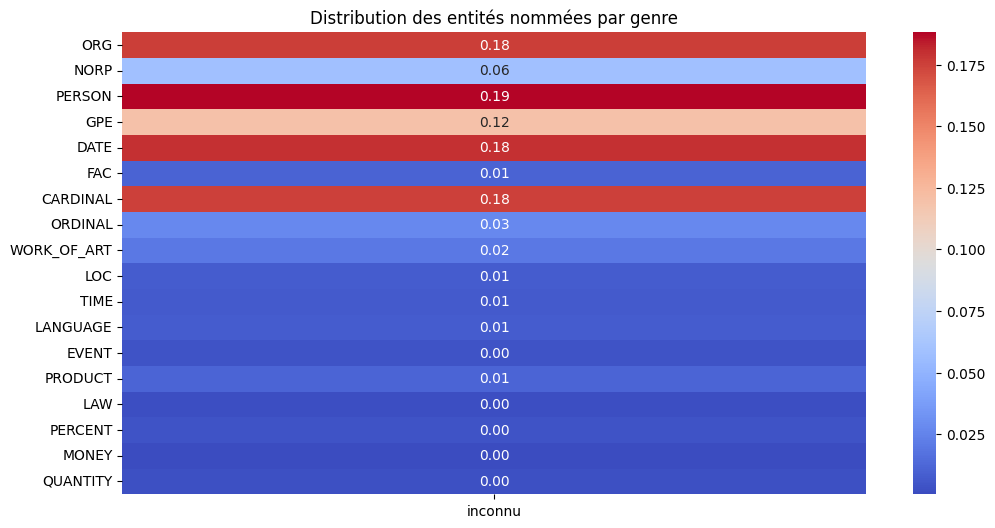

In [12]:

df_ner = pd.DataFrame(ner_genre).fillna(0)
df_ner = df_ner.div(df_ner.sum(axis=0), axis=1)

plt.figure(figsize=(12, 6))
sns.heatmap(df_ner, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Distribution des entités nommées par genre')
plt.show()

### Chi-Squared Test and Wordcloud for Named Entity Recognition (NER)

1. **Chi-Squared Test**: This block performs a chi-squared test to assess if there are significant differences in the distribution of named entities across genres. The `chi2_contingency` function uses the `ner_genre` data to compute the p-value, indicating whether the distribution of named entities differs significantly between genres.

   - **p-value**: The result shows the p-value, which indicates whether the differences in named entity distribution between genres are statistically significant.

2. **Wordcloud Visualization**: A word cloud is generated from the frequency counts of named entities (`ner_counter`). The word cloud visualizes the most frequent named entities, with the size of each word representing its frequency.

   - **Wordcloud**: The word cloud offers a visual summary of the most common named entities in the dataset, highlighting those that appear most frequently.



Significativité des différences entre genres (NER): p=1.0000


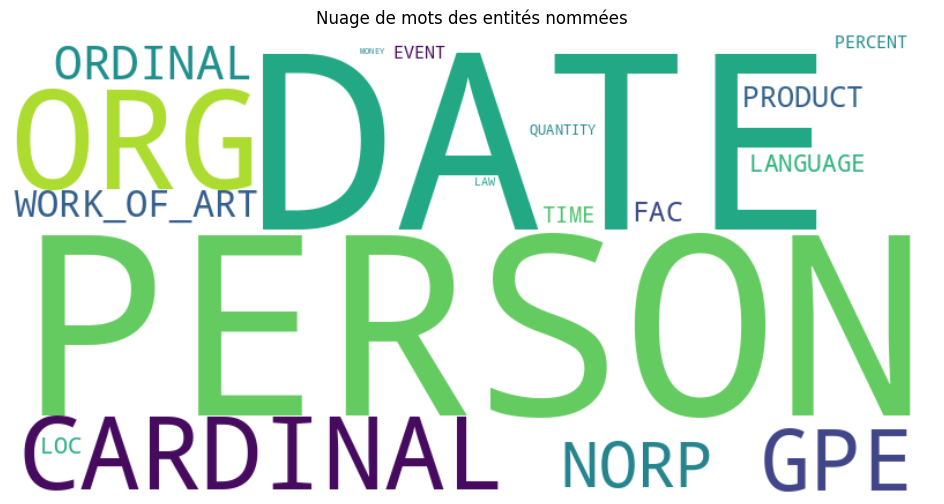

In [13]:

data_ner = [list(ner_genre[g].values()) for g in ner_genre.keys()]
chi2_ner, p_ner, _, _ = chi2_contingency(data_ner)
print(f"\nSignificativité des différences entre genres (NER): p={p_ner:.4f}")


wordcloud_ner = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(ner_counter)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_ner, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots des entités nommées")
plt.show()

##Senetiment analysis


### Sentiment Analysis, Sentence Embeddings, and Clustering

1. **Sentiment Analysis**:
   - The `get_sentiment` function calculates the sentiment polarity for each sentence using the `TextBlob` library. Sentiment polarity ranges from -1 (negative) to 1 (positive). The function returns a list of sentiment scores for all sentences.

2. **Sentence Embeddings**:
   - The `compute_sentence_embeddings` function generates vector embeddings for each sentence using a pre-trained `spaCy` model. Each sentence is transformed into a dense vector representation, which captures the semantic meaning of the sentence.

3. **Dimensionality Reduction and Visualization**:
   - The `visualize_embeddings` function uses either t-SNE or PCA to reduce the dimensionality of the sentence embeddings to 2D, making it possible to visualize the embeddings in a 2D scatter plot. This plot represents the semantic space of the sentences.

4. **Sentence Clustering**:
   - The `cluster_sentences` function applies KMeans clustering to group sentences based on their embeddings. The number of clusters can be specified, and each sentence is assigned to a cluster.

5. **Sentiment Distribution Plot**:
   - The `plot_sentiment_distribution` function generates a histogram to visualize the distribution of sentiment scores across the sentences, showing how positive or negative the overall sentiment of the dataset is.

- **Visualizations**:
  - **Sentiment Distribution**: The histogram displays the distribution of sentiment polarity scores across the sentences.
  - **Embeddings Visualization**: The scatter plot shows the 2D representation of sentence embeddings, allowing you to visualize the relationships between different sentences.


In [6]:
pip install textblob

In [7]:
from textblob import TextBlob
def get_sentiment(sentences):
    sentiment_scores = []

    for sent in sentences:
        text = " ".join([token['form'] for token in sent])
        sentiment = TextBlob(text).sentiment.polarity  # Polarity score [-1,1]
        sentiment_scores.append(sentiment)

    return sentiment_scores

In [8]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
def compute_sentence_embeddings(sentences):
    embeddings = []

    for sent in sentences:
        text = " ".join([token['form'] for token in sent])
        doc = nlp(text)
        embeddings.append(doc.vector)

    return np.array(embeddings)

def visualize_embeddings(embeddings, method='tsne'):
    if method == 'tsne':
        reduced = TSNE(n_components=2, perplexity=30).fit_transform(embeddings)
    else:
        reduced = PCA(n_components=2).fit_transform(embeddings)

    plt.figure(figsize=(10, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.7)
    plt.title(f'Sentence Embeddings ({method.upper()})')
    plt.show()

def cluster_sentences(embeddings, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings)
    return clusters


In [13]:
def plot_sentiment_distribution(sentiment_scores):
    plt.figure(figsize=(10, 5))
    sns.histplot(sentiment_scores, bins=20, kde=True, color='blue')
    plt.title('Sentiment Score Distribution')
    plt.xlabel('Sentiment Polarity')
    plt.ylabel('Frequency')
    plt.show()



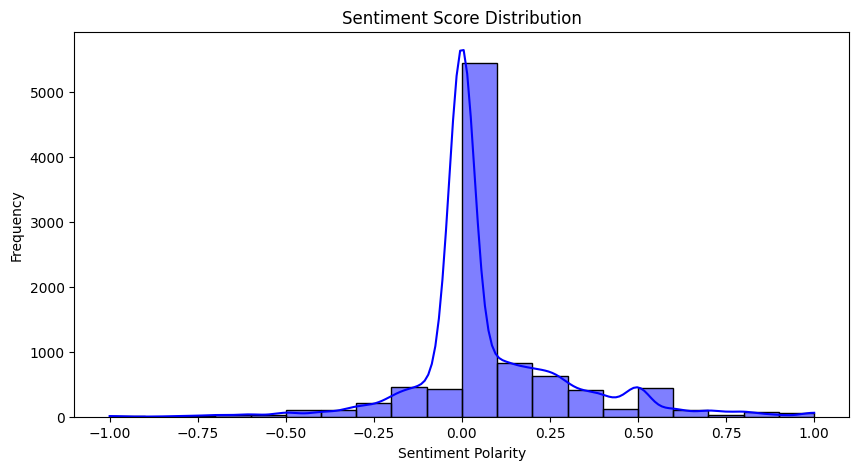

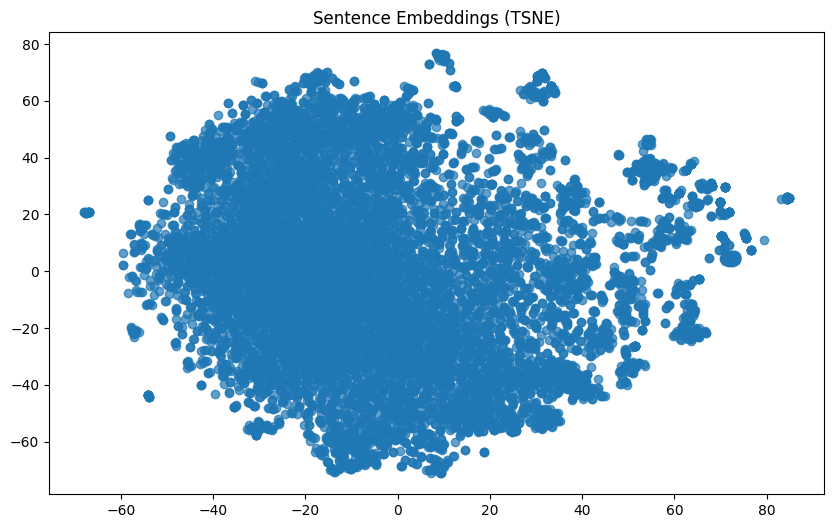

In [14]:
sentiment_scores = get_sentiment(sentences)
embeddings = compute_sentence_embeddings(sentences)


# Visualization
plot_sentiment_distribution(sentiment_scores)
visualize_embeddings(embeddings, method='tsne')

## Readability Analysis and Author Style Profiling


In [15]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 82.5 MB/s eta 0:00:00


1. **Readability Analysis**:
   - The `compute_readability` function calculates readability scores for each sentence using three different metrics:
     - **Flesch Reading Ease**: A higher score indicates the text is easier to read.
     - **Flesch-Kincaid Grade Level**: A higher score suggests more complex text suitable for higher educational levels.
     - **Dale-Chall Readability Score**: A score based on the familiarity of words used, helping to measure text complexity.
   - These scores are computed for each sentence, and a tuple of scores is returned for each sentence.

2. **Visualization of Readability Scores**:
   - **Flesch Reading Ease Distribution**: A histogram with a KDE (Kernel Density Estimation) curve shows the distribution of Flesch Reading Ease scores across the sentences.
   - **Flesch Reading Ease vs. Grade Level**: A scatter plot displays the relationship between the Flesch Reading Ease score and the Flesch-Kincaid Grade Level, helping to visualize how easy the text is to read in comparison to the grade level.

3. **Author Style Profiling**:
   - The `author_styles` dictionary tracks various features of each author’s writing style:
     - **Word Length**: Length of each word in the sentence.
     - **Sentence Length**: The number of words in the sentence.
     - **POS Distribution**: The frequency distribution of part-of-speech (POS) tags in the sentence.
   - This information is gathered for each author and stored in the `author_styles` dictionary, where each author is associated with lists of word lengths, sentence lengths, and POS tag frequencies.

### Visualizations:
- **Flesch Reading Ease Distribution**: The histogram displays how easy the sentences are to read according to the Flesch Reading Ease score.
- **Flesch Reading Ease vs. Grade Level**: The scatter plot helps analyze the relationship between readability and the educational grade level required to understand the text.


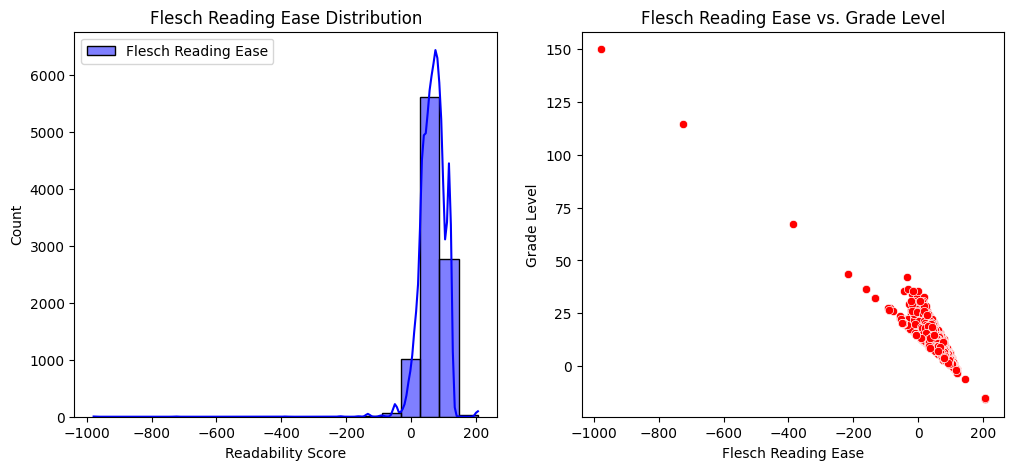

In [6]:
import textstat
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np



def compute_readability(sentences):
    scores = []
    for sent in sentences:
        text = " ".join([token['form'] for token in sent])
        flesch_reading_ease = textstat.flesch_reading_ease(text)
        flesch_grade_level = textstat.flesch_kincaid_grade(text)
        dale_chall = textstat.dale_chall_readability_score(text)
        scores.append((flesch_reading_ease, flesch_grade_level, dale_chall))

    return scores

# Compute readability scores
readability_scores = compute_readability(sentences)

# Convert to numpy array for easy processing
readability_scores = np.array(readability_scores)
flesch, grade, dale = readability_scores[:,0], readability_scores[:,1], readability_scores[:,2]

# Visualization - Readability Scores
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(flesch, bins=20, kde=True, color='blue', label="Flesch Reading Ease")
plt.xlabel("Readability Score")
plt.title("Flesch Reading Ease Distribution")
plt.legend()

plt.subplot(1,2,2)
sns.scatterplot(x=flesch, y=grade, color='red')
plt.xlabel("Flesch Reading Ease")
plt.ylabel("Grade Level")
plt.title("Flesch Reading Ease vs. Grade Level")
plt.show()

author_styles = defaultdict(lambda: {"word_length": [], "sentence_length": [], "pos_dist": defaultdict(int)})

for sent in sentences:
    author = sent.metadata.get("author", "Unknown")  # Extract author info
    words = [token['form'] for token in sent]
    pos_tags = [token['upostag'] for token in sent]

    author_styles[author]["word_length"].extend([len(word) for word in words])
    author_styles[author]["sentence_length"].append(len(words))

    for pos in pos_tags:
        author_styles[author]["pos_dist"][pos] += 1




## Text Cohesion


In [6]:
!pip install nltk

In [7]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

import networkx as nx
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import itertools

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
pip install adjustText

### Word Co-occurrence Network Visualization
 we create a **Word Co-occurrence Network** from a corpus of text. The network visualizes relationships between words based on how frequently they co-occur within the same sentence. We use various Python libraries such as `nltk`, `networkx`, and `matplotlib` to tokenize the text, calculate word co-occurrence, create a graph representation, and visualize the results. The visualization helps us understand which words are central in the text and how they are connected to one another.

## Project Overview

The process involves the following key steps:
1. **Text Tokenization**: Split the sentences into individual words and prepare the text for analysis.
2. **Co-occurrence Calculation**: Calculate how often pairs of words appear together in the same sentence.
3. **Graph Creation**: Create a graph where nodes represent words and edges represent the co-occurrence between words.
4. **Visualization**: Visualize the graph with nodes sized by word frequency, colored by centrality, and edges weighted by co-occurrence strength.

## Step-by-Step Breakdown

### 1. **Tokenization of Text**
We begin by tokenizing each sentence into words. This involves converting the text to lowercase and then using `nltk.word_tokenize` to split the text into individual tokens.

```python
text_sentences = [" ".join([token["form"] for token in sent]) for sent in sentences]
tokenized_docs = [nltk.word_tokenize(sent.lower()) for sent in text_sentences]


In [ ]:
import networkx as nx
from adjustText import adjust_text


text_sentences = [" ".join([token["form"] for token in sent]) for sent in sentences]
tokenized_docs = [nltk.word_tokenize(sent.lower()) for sent in text_sentences]

word_counts = Counter(itertools.chain(*tokenized_docs))
co_occurrence = {}

for doc in tokenized_docs:
    for word1, word2 in itertools.combinations(set(doc), 2):
        pair = tuple(sorted([word1, word2]))
        co_occurrence[pair] = co_occurrence.get(pair, 0) + 1


G = nx.Graph()
for (word1, word2), weight in co_occurrence.items():
    if weight > 3:
        G.add_edge(word1, word2, weight=weight)


node_sizes = [word_counts[node] * 150 for node in G.nodes()]
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
edge_weights = [w * 0.3 for w in edge_weights]


centrality = nx.degree_centrality(G)
node_colors = [centrality[node] for node in G.nodes()]


plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G, k=1.2, scale=3, iterations=50)


nx.draw_networkx_nodes(G, pos, node_size=node_sizes, cmap=plt.cm.Blues,
                       node_color=node_colors, alpha=0.85, edgecolors='black')


nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='gray', alpha=0.4)


texts = []
for node, (x, y) in pos.items():
    texts.append(plt.text(x, y, node, fontsize=10, fontweight='bold'))

adjust_text(texts, expand_points=(1.3, 1.5), force_text=(0.5, 1.0))

plt.title("Enhanced Word Co-occurrence Network", fontsize=16, fontweight="bold")
plt.show()


### Topic Modeling with Latent Dirichlet Allocation (LDA)

It demonstrates the process of applying **Topic Modeling** to a collection of text sentences using **Latent Dirichlet Allocation (LDA)**. Topic modeling is a technique in Natural Language Processing (NLP) that automatically discovers the underlying topics in a large corpus of text. In this implementation, we first clean the text data, then apply LDA to uncover topics, and finally visualize the most significant words for each topic.


These are the steps :
1. **Text Cleaning**: Remove common stopwords, filler words, and non-alphabetic tokens.
2. **Text Vectorization**: Convert the cleaned text into a matrix of word counts using **CountVectorizer**.
3. **Topic Modeling (LDA)**: Apply Latent Dirichlet Allocation to discover the underlying topics.
4. **Topic-Word Distribution**: Extract and display the top words for each topic along with their importance scores.
5. **Visualization**: Plot a bar chart showing the importance of words in each topic.

## Step-by-Step Breakdown

### 1. **Define Custom Stopwords**

We start by defining custom stopwords, which include common words like auxiliary verbs and filler words that are typically not useful for analysis. These custom stopwords are then combined with the default set of stopwords from the NLTK corpus.

```python
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')

custom_stopwords = set(stopwords.words('english'))
common_filler_words = {"like", "just", "know", "yeah", "okay", "right", "don", "did", "ve", "got", "oh", "really", "uh", "ll", "let", "called"}
all_stopwords = custom_stopwords.union(common_filler_words)


In [2]:
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')

custom_stopwords = set(stopwords.words('english'))
common_filler_words = {"like", "just", "know", "yeah", "okay", "right", "don", "did", "ve", "got", "oh", "really", "uh", "ll", "let", "called"}
all_stopwords = custom_stopwords.union(common_filler_words)

def clean_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in all_stopwords]
    return " ".join(filtered_tokens)


cleaned_sentences = [clean_text(sentence) for sentence in text_sentences]


vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(cleaned_sentences)


num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)


def display_topics_with_weights(model, feature_names, num_words=8):
    topic_data = []

    for topic_idx, topic in enumerate(model.components_):
        top_features = topic.argsort()[:-num_words - 1:-1]
        words = [feature_names[i] for i in top_features if feature_names[i] not in all_stopwords]  # Filter stopwords
        weights = topic[top_features]

        for word, weight in zip(words, weights):
            topic_data.append([f"Topic {topic_idx + 1}", word, weight])

    return pd.DataFrame(topic_data, columns=["Topic", "Word", "Weight"])


df_topics = display_topics_with_weights(lda, vectorizer.get_feature_names_out())


plt.figure(figsize=(12, 6))
sns.barplot(data=df_topics, x="Weight", y="Word", hue="Topic", dodge=False, palette="viridis")
plt.title("Top Words in Each Topic (with Weights)")
plt.xlabel("Importance Weight")
plt.ylabel("Words")
plt.legend(title="Topic", bbox_to_anchor=(1, 1))
plt.show()

for topic in df_topics["Topic"].unique():
    topic_words = df_topics[df_topics["Topic"] == topic][["Word", "Weight"]].values
    formatted_words = ", ".join(f"{word} ({weight:.2f})" for word, weight in topic_words)
    print(f"\n🔹 {topic}: {formatted_words}")

AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)